### Dane z https://github.com/furqan4545/handwritten_text_detection_and_recognition.git

In [5]:
from word_detector import prepare_img, detect, sort_line
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [6]:
from transformer import *

In [7]:
augument = transforms.Compose([
    transforms.RandomRotation(15, expand=True, fill=(255,)),
    transforms.RandomAffine(0, translate=(0.05, 0.05), fill=(255,)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5, fill=(255,)),
    transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
])

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 128)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 1.0 - x),
    transforms.Normalize((0.5,), (0.5,)),
])

In [8]:
train_dataset = HandWritingDataset('words_data/train', transform=transform, label_transofrm=Params.encode_string) # augument data
# train_dataset = H5Dataset('train_data.h5', num_epochs=1)
val_dataset = HandWritingDataset(root='words_data/val', transform=transform, label_transofrm=Params.encode_string)

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=0, sampler=train_dataset.create_sampler(), collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0, shuffle=True, collate_fn=collate_fn)

model = HandwritingTransformer(
    input_size=16 * 24,
    vocab_size=len(Params.vocab)+2,
    d_model=128,
    nhead_en=1,
    num_layers_en=1,
    nhead_de=1,
    num_layers_de=1,
    dropout=0.2
).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=0).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
early_stopping = EarlyStopping(patience=5)
history = TrainingHistory()

/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/jakub/miniconda3/envs/torch/lib/python3.13/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


In [9]:
train(
    model=model,
    train_loader=val_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    epochs=20,
    early_stopping=early_stopping,
    history=history
)

Epoch:    1/20 100% | Elapsed:   3s | loss: 2.5216 - acc: 0.1260 | val_loss: 1.9853 - val_acc: 0.1784
Epoch:    2/20 100% | Elapsed:   2s | loss: 2.0987 - acc: 0.1672 | val_loss: 1.7859 - val_acc: 0.2032
Epoch:    3/20 100% | Elapsed:   2s | loss: 1.9576 - acc: 0.1836 | val_loss: 1.6634 - val_acc: 0.2175
Epoch:    4/20 100% | Elapsed:   2s | loss: 1.8697 - acc: 0.1960 | val_loss: 1.5635 - val_acc: 0.2313
Epoch:    5/20 100% | Elapsed:   2s | loss: 1.7657 - acc: 0.2058 | val_loss: 1.4563 - val_acc: 0.2456
Epoch:    6/20 100% | Elapsed:   2s | loss: 1.6908 - acc: 0.2200 | val_loss: 1.3481 - val_acc: 0.2576
Epoch:    7/20 100% | Elapsed:   2s | loss: 1.6318 - acc: 0.2264 | val_loss: 1.2896 - val_acc: 0.2643
Epoch:    8/20 100% | Elapsed:   2s | loss: 1.5681 - acc: 0.2324 | val_loss: 1.2255 - val_acc: 0.2799
Epoch:    9/20 100% | Elapsed:   2s | loss: 1.4943 - acc: 0.2408 | val_loss: 1.1417 - val_acc: 0.2899
Epoch:   10/20 100% | Elapsed:   2s | loss: 1.4667 - acc: 0.2447 | val_loss: 1.123

In [11]:
torch.save(model.state_dict(), 'handwriting_transformer.pth')

In [12]:
test_dataset = HandWritingDataset(root='words_data/test', transform=transform, label_transofrm=Params.encode_string)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=0, shuffle=True, collate_fn=collate_fn)

val_with_outs = ValidatorWithOutputs(model, criterion, device)
outputs = val_with_outs.validate(test_loader)

for i, (predicted, expected) in enumerate(outputs):
    if i > 100:
        break
    predicted = Params.decode_string([i for i in predicted if i not in [27, 28]])
    expected = Params.decode_string([i for i in expected if i not in [27, 28]])
    print(f"{predicted.ljust(12)}  -  {expected.ljust(12)}")

capeactlly    -  explicably  
peceecice     -  possessive  
tt            -  it          
he            -  her         
as            -  are         
the           -  the         
motvmumtetso  -  melodramatic
ceosd         -  drunk       
with          -  with        
and           -  and         
bf            -  of          
while         -  whole       
munhed        -  sacred      
boe           -  the         
wse           -  use         
aorie         -  party       
meccd         -  viewed      
befere        -  before      
an            -  on          
ase           -  are         
thllh         -  touch       
secedted      -  selected    
memmmament    -  rearmament  
a             -  a           
aoueeneion    -  conception  
sse           -  are         
onme          -  arms        
af            -  of          
they          -  they        
aecened       -  decided     
not           -  not         
forr          -  foot        
wear          -  week        
fntereese 

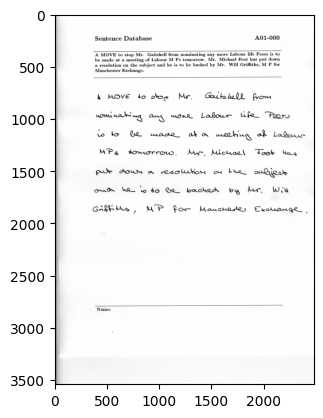

In [14]:
# img = prepare_img(cv2.imread('data/line/0.png'), 50)
img = cv2.imread('data/000/a01-000u.png')
img = prepare_img(img, img.shape[0])
# (2) detect words in image
detections = detect(img,
                    kernel_size=25,
                    sigma=11,
                    theta=7,
                    min_area=500)

# (3) sort words in line
line = sort_line(detections)[0]

# (4) show word images
plt.imshow(img, cmap='gray')

In [ ]:
# plt.subplot(len(line), 1, 1)
# for i, word in enumerate(line):
#   print(word.bbox)
#   plt.subplot(len(line), 1, i + 1)
#   plt.imshow(word.img, cmap='gray')
# plt.savefig('line.png')
# plt.imshow(line[0].img, cmap='gray')

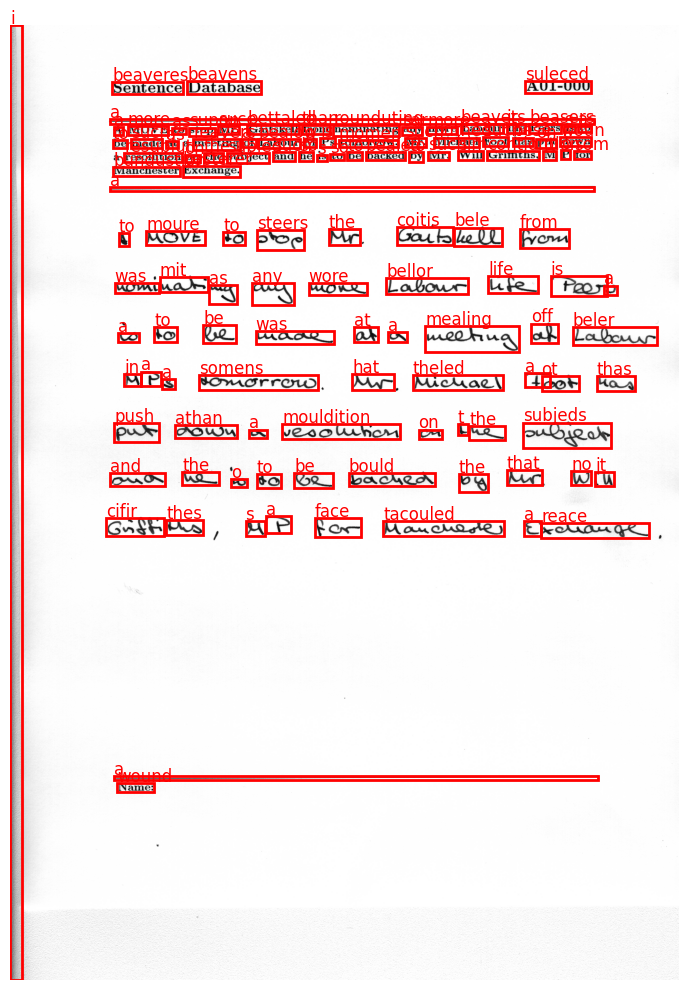

In [15]:
# Process detections through the handwriting recognition model
def predict_from_detections(detections, model, transform):
    model.eval()
    results = []
    
    with torch.no_grad():
        for det in detections:
            # Convert the detected word image to PIL format
            word_img = Image.fromarray(det.img)
            
            # Apply the same transformations used during training
            img_tensor = transform(word_img).unsqueeze(0).to(device)
            
            # Start with the SOS token
            input_token = torch.tensor([[27]]).to(device)
            
            # Generate tokens one by one
            generated_tokens = [27]  # Start with SOS token
            max_length = 20  # Set maximum word length
            
            for _ in range(max_length):
                output = model(img_tensor, input_token)
                next_token = output[0, -1].argmax().item()
                generated_tokens.append(next_token)
                
                # Stop if we reach EOS token
                if next_token == 28:
                    break
                
                # Update input token for next prediction
                input_token = torch.cat([input_token, torch.tensor([[next_token]]).to(device)], dim=1)
            
            # Convert tokens to text
            pred_text = Params.decode_string([i for i in generated_tokens if i not in [27, 28]])
            results.append((det.bbox, pred_text))
    
    return results

# Run predictions on detections
predictions = predict_from_detections(detections, model, transform)

# Display results with bounding boxes and predicted text
plt.figure(figsize=(15, 10))
plt.imshow(img, cmap='gray')

for bbox, text in predictions:
    plt.gca().add_patch(plt.Rectangle((bbox.x, bbox.y), bbox.w, bbox.h, 
                                     fill=False, edgecolor='red', linewidth=2))
    plt.text(bbox.x, bbox.y-5, text, color='red', fontsize=12)

plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import cv2

# Open the default camera
cam = cv2.VideoCapture(0)

# Get the default frame width and height
frame_width = int(cam.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cam.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output.mp4', fourcc, 20.0, (frame_width, frame_height))

while True:
    ret, frame = cam.read()

    # Write the frame to the output file
    out.write(frame)

    # Display the captured frame
    cv2.imshow('Camera', frame)

    # Press 'q' to exit the loop
    if cv2.waitKey(1) == ord('q'):
        break

# Release the capture and writer objects
cam.release()
out.release()
cv2.destroyAllWindows()

error: OpenCV(4.10.0) C:\b\abs_e4cxka7_7g\croot\opencv-suite_1738943368733\work\modules\highgui\src\window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'
